In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np


In [36]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

def load_images(file_path):
    with open(file_path, 'rb') as f:
        header = np.frombuffer(f.read(16), dtype=np.uint32).view(np.dtype('>u4'))  # Big-endian uint32
        magic, num_images, rows, cols = header
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
    return images

def load_labels(file_path):
    with open(file_path, 'rb') as f:
        header = np.frombuffer(f.read(8), dtype=np.uint32).view(np.dtype('>u4'))  # Big-endian uint32
        magic, num_labels = header
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels


# File paths
train_images_path = 'train-images-idx3-ubyte'
train_labels_path = 'train-labels-idx1-ubyte'
test_images_path = 't10k-images-idx3-ubyte'
test_labels_path = 't10k-labels-idx1-ubyte'

# Load data
train_images = load_images(train_images_path)
train_labels = load_labels(train_labels_path)
test_images = load_images(test_images_path)
test_labels = load_labels(test_labels_path)

# Normalize images (MNIST normalization)
train_images = (train_images / 255.0 - 0.1307) / 0.3081
test_images = (test_images / 255.0 - 0.1307) / 0.3081

# Convert to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32).view(-1, 28 * 28)  # Flatten images
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32).view(-1, 28 * 28)  # Flatten images
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

print(f"Training set: {len(train_loader)} batches")
print(f"Test set: {len(test_loader)} batches")


Training set: 937 batches
Test set: 156 batches


In [37]:
from neural_ode import NeuralODENetwork
from solvers import EulerSolver, RK45Solver, AdaptiveRK45Solver

In [38]:
INPUT_DIM = 784  # MNIST images are 28x28
NUM_CLASSES = 10  # Digits 0-9

latent_converter = nn.Sequential(
    nn.Linear(INPUT_DIM, 128),
    nn.ReLU()
)

dynamics_approximator = nn.Sequential(
    nn.Linear(128 + 1, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 128),
    nn.ReLU()
)

classifier_head = nn.Sequential(
    nn.Linear(128, NUM_CLASSES)
)

solver = RK45Solver(timesteps_number=10, time_range=(0, 1)) # NEURAL ODE WITH 10 TIMESTEPS
n_ode = NeuralODENetwork(latent_dynamics_function=dynamics_approximator, solver=solver)

n_ode.attach_pre_solver_function(latent_converter)
n_ode.attach_task_head(classifier_head)


In [39]:
INPUT_DIM = 784  # MNIST images are 28x28
NUM_CLASSES = 10  # Digits 0-9

latent_converter = nn.Sequential(
    nn.Linear(INPUT_DIM, 128),
    nn.ReLU()
)

dynamics_approximator = nn.Sequential(
    nn.Linear(128 + 1, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 128),
    nn.ReLU()
)

classifier_head = nn.Sequential(
    nn.Linear(128, NUM_CLASSES)
)

solver = AdaptiveRK45Solver(time_range=(0, 1), max_step_size=0.1, min_step_size=0.01,include_state_in_dynamics=True) #NODE WITH ADAPTIVE
n_ode_2 = NeuralODENetwork(latent_dynamics_function=dynamics_approximator, solver=solver)

n_ode_2.attach_pre_solver_function(latent_converter)
n_ode_2.attach_task_head(classifier_head)


In [40]:
def train_and_evaluate_mnist_model(model, train_loader, test_loader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images = images.view(-1, 28 * 28)  # Flatten MNIST images
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(-1, 28 * 28)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(correct / total)

        print(
            f"Epoch [{epoch + 1}/{epochs}] "
            f"Train Loss: {train_losses[-1]:.4f}, "
            f"Test Loss: {test_losses[-1]:.4f}, "
            f"Test Accuracy: {test_accuracies[-1]:.4f}"
        )

    return train_losses, test_losses, test_accuracies


# TRAINING LOOP FOR MNIST, EPOCH EVAL 

In [41]:
def plot_metrics(train_losses, test_losses, test_accuracies):
    # Plot Losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Test Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [42]:
def train_and_evaluate_per_step(model, train_loader, test_loader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()
        for batch_idx, (images, labels) in enumerate(train_loader):
            # Training step
            images = images.view(-1, 28 * 28)  # Flatten MNIST images
            optimizer.zero_grad()
            print(f"Input batch size: {images.size(0)}")
            outputs = model(images)
            print(f"Output batch size: {outputs.size(0)}")
            print(f"Labels batch size: {labels.size(0)}")
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Log training loss
            train_losses.append(loss.item())

            # Calculate training accuracy for the batch
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            train_accuracy = correct / labels.size(0)

            print(
                f"Step {batch_idx + 1}/{len(train_loader)} - "
                f"Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}"
            )

            # Periodically evaluate on the test set
            if (batch_idx + 1) % 100 == 0 or batch_idx == len(train_loader) - 1:
                model.eval()
                test_loss = 0.0
                correct = 0
                total = 0
                with torch.no_grad():
                    for images, labels in test_loader:
                        images = images.view(-1, 28 * 28)
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        test_loss += loss.item()
                        _, predicted = torch.max(outputs, 1)
                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)

                test_losses.append(test_loss / len(test_loader))
                test_accuracy = correct / total
                test_accuracies.append(test_accuracy)

                print(
                    f"    Test Loss: {test_loss / len(test_loader):.4f}, "
                    f"Test Accuracy: {test_accuracy:.4f}"
                )
                model.train()  # Switch back to training mode

    return train_losses, test_losses, test_accuracies

#TRAINING LOOP FOR MNIST PER TRAIN STEP, FOR MORE INFO 

In [43]:
# Train the model and collect metrics
epochs = 15
train_losses_2, test_losses_2, test_accuracies_2 = train_and_evaluate_per_step(
    n_ode_2, train_loader, test_loader, epochs
)

# Visualize the metrics
plot_metrics(train_losses_2, test_losses_2, test_accuracies_2)

Epoch 1/15
Input batch size: 64
Output batch size: 21
Labels batch size: 64


ValueError: Expected input batch_size (21) to match target batch_size (64).

In [44]:
# Train the model and collect metrics
epochs = 15
train_losses, test_losses, test_accuracies = train_and_evaluate_mnist_model(
    n_ode, train_loader, test_loader, epochs
)

# Visualize the metrics
plot_metrics(train_losses, test_losses, test_accuracies)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x1 and 129x64)

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleMLP(nn.Module):
    def __init__(self, input_dim=784, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),  # Match Neural ODE's latent space size
            nn.ReLU(),
            nn.Linear(128, 64),        # Similar structure as dynamics_approximator
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)  # Output layer for classification
        )

    def forward(self, x):
        return self.net(x)


In [21]:
mlp_model = SimpleMLP()
train_losses_mlp, test_losses_mlp, test_accuracies_mlp = train_and_evaluate_per_step(
    mlp_model, train_loader, test_loader, epochs=15
)


Epoch 1/15
Step 1/938 - Train Loss: 2.2918, Train Accuracy: 0.0938
Step 2/938 - Train Loss: 2.3028, Train Accuracy: 0.0312
Step 3/938 - Train Loss: 2.2935, Train Accuracy: 0.2500
Step 4/938 - Train Loss: 2.3047, Train Accuracy: 0.2188
Step 5/938 - Train Loss: 2.2921, Train Accuracy: 0.1562
Step 6/938 - Train Loss: 2.2979, Train Accuracy: 0.1406
Step 7/938 - Train Loss: 2.2825, Train Accuracy: 0.1406
Step 8/938 - Train Loss: 2.2845, Train Accuracy: 0.2188
Step 9/938 - Train Loss: 2.2743, Train Accuracy: 0.2031
Step 10/938 - Train Loss: 2.2646, Train Accuracy: 0.1875
Step 11/938 - Train Loss: 2.2595, Train Accuracy: 0.2500
Step 12/938 - Train Loss: 2.2334, Train Accuracy: 0.2344
Step 13/938 - Train Loss: 2.2415, Train Accuracy: 0.2188
Step 14/938 - Train Loss: 2.2174, Train Accuracy: 0.2031
Step 15/938 - Train Loss: 2.1782, Train Accuracy: 0.2656
Step 16/938 - Train Loss: 2.2097, Train Accuracy: 0.3281
Step 17/938 - Train Loss: 2.2122, Train Accuracy: 0.1875
Step 18/938 - Train Loss: 2.1

KeyboardInterrupt: 

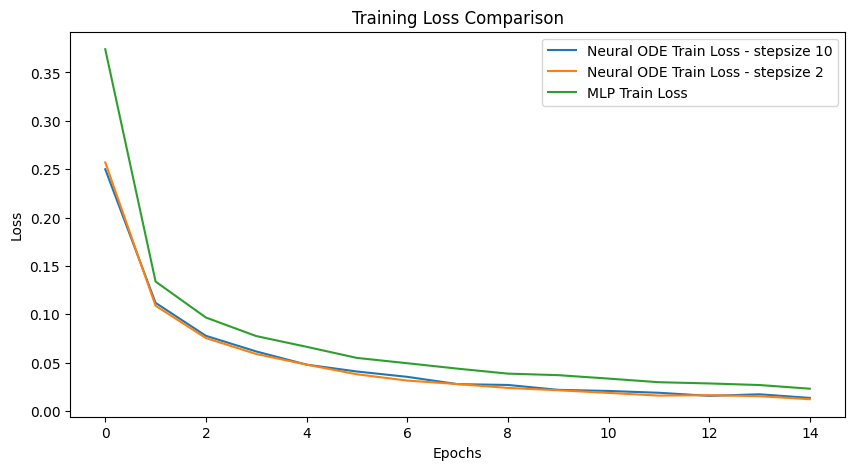

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Neural ODE Train Loss - stepsize 10")
plt.plot(train_losses_2, label="Neural ODE Train Loss - stepsize 2")
plt.plot(train_losses_mlp, label="MLP Train Loss")
plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


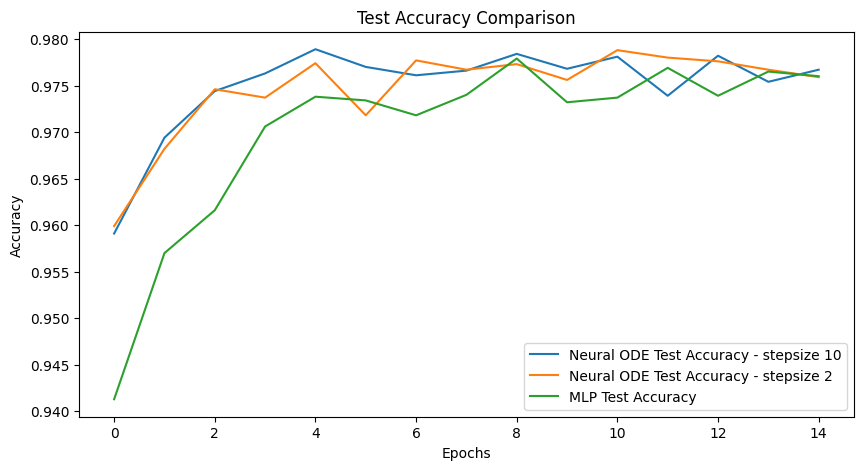

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label="Neural ODE Test Accuracy - stepsize 10")
plt.plot(test_accuracies_2, label="Neural ODE Test Accuracy - stepsize 2")
plt.plot(test_accuracies_mlp, label="MLP Test Accuracy")
plt.title("Test Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
